In [2]:
import functools
!pip install -q -U langchain-openai langgraph langchain


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults
import os
os.environ['TAVILY_API_KEY']="tvly-AIAghtTeT"
os.environ['LANGCHAIN_API_KEY']="lsv2_pt_45936eaf6b3972"

print(os.environ['TAVILY_API_KEY'])
# print(os.environ['TAVILY_API_KEY'])
search =  TavilySearchResults(max_results = 2, TAVILY_API_KEY=os.environ['TAVILY_API_KEY'])
search_results = search.invoke("what is the weather in SF")
print(search_results)

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
[{'url': 'https://www.weatherapi.com/', 'content': "{'location': {'name': 'San Francisco', 'region': 'California', 'country': 'United States of America', 'lat': 37.78, 'lon': -122.42, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1724599840, 'localtime': '2024-08-25 08:30'}, 'current': {'last_updated_epoch': 1724599800, 'last_updated': '2024-08-25 08:30', 'temp_c': 17.2, 'temp_f': 63.0, 'is_day': 1, 'condition': {'text': 'Partly cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/day/116.png', 'code': 1003}, 'wind_mph': 2.2, 'wind_kph': 3.6, 'wind_degree': 10, 'wind_dir': 'N', 'pressure_mb': 1021.0, 'pressure_in': 30.14, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 87, 'cloud': 25, 'feelslike_c': 17.2, 'feelslike_f': 63.0, 'windchill_c': 16.0, 'windchill_f': 60.7, 'heatindex_c': 15.9, 'heatindex_f': 60.5, 'dewpoint_c': 11.6, 'dewpoint_f': 52.8, 'vis_km': 16.0, 'vis_miles': 9.0, 'uv': 5.0, 'gust_mph': 3.8, 'gust_kph': 6.0}}"}, {'url': 'http

In [36]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain.output_parsers.openai_functions import JsonKeyOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END
from langchain.tools import tool
from langchain_openai import ChatOpenAI
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict

In [37]:
llm = ChatOpenAI(model = "gpt-4o-mini") 

In [38]:
from langchain_core.messages import (
BaseMessage, HumanMessage,AIMessage, ChatMessage, FunctionMessage, SystemMessage
)
@tool("web_search")
def web_search(query: str)-> str :
    """search with api"""
    search = TavilySearchResults(max_results =2)
    return search.invoke(query)

@tool("twitter_writer")
def write_tweet(content: str) -> str:
    """Base on a piece content, write a tweet"""
    chat = ChatOpenAI(model = "gpt-4o-mini") 
    message = [
        SystemMessage(content="you are a Twitter account operator. you are responsible for writing a tweet base on the content given. you should fellow the twitter policy and make sure the twitter nno more than 1400 characters"),
        HumanMessage(content=content)
    ]
    response = chat.invoke(message)
    return response.content

In [39]:
import operator


class AgentState(TypedDict):
    # the Annotated tell the graph that the messages will always be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # the next field indicates where to route to next
    next: str

In [40]:
def create_agent(llm: ChatOpenAI, tools: list, system_message: SystemMessage):
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_message),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ])
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

In [41]:
def create_node(state: AgentState, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

In [42]:
members = ["Search_Engine", "Twitter_Writer"]
system_prompt = "You are a supervisor tasked with managing a conversation between the following workers: {members}. Given the following user request, respond with the worker to act next. Each worker will perform a task and respond with their results and status. When finished, respond with FINISH."

options = ["FINISH"] + members
# use openai function calling can make output parser easier for us
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title":"routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title":"Next",
                "anyof": [
                    {"enum": options}
                ]
            }
        },
        "require": ["next"],
    },
}

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system", 
            "Given the conversion above, who should act next or should we FINISH? select one of : {options}"
        ),
    ]
).partial(options=str(options), members=", ".join(members))

In [43]:
supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonKeyOutputFunctionsParser
)


In [44]:
from functools import partial

search_engine_agent = create_agent(llm, [web_search], "you are a web search engine")
search_engine_node = partial(create_node, agent=search_engine_agent, name="Search_Engine")


twitter_operate_agent = create_agent(llm, [write_tweet], "you are responsible for writing a tweet base on the content given")
twitter_operate_node = partial(create_node, agent=twitter_operate_agent, name="Twitter_Writer")


In [45]:
workflow = StateGraph(AgentState)
workflow.add_node("Search_Engine", search_engine_node)
workflow.add_node("Twitter_Writer", twitter_operate_node)
workflow.add_node("supervisor", supervisor_chain)

for member in members:
    workflow.add_edge(member, "supervisor")
    
conditional_map = {k: k for k in members}
conditional_map["FINISH"]=END
print(conditional_map)
workflow.add_conditional_edges("supervisor", lambda x:x["next"], conditional_map)

workflow.set_entry_point("supervisor")

graph = workflow.compile()

{'Search_Engine': 'Search_Engine', 'Twitter_Writer': 'Twitter_Writer', 'FINISH': '__end__'}


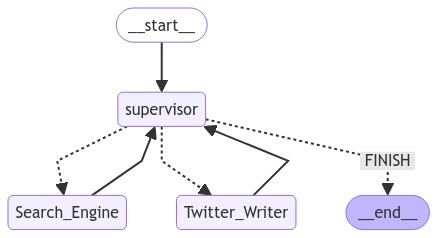

In [49]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [48]:

for s in graph.stream(
        {
            "messages": [
                HumanMessage(content="write a tweet about langchain news")
            ]
        }
): 
    if "__end__" not in s:
        print(s)
        print("--------")

TypeError: BaseModel.__init__() takes 1 positional argument but 2 were given

In [ ]:
# 新的demo

def my_node(state, config): 
    return {"x": state["x"] + 1}